In [7]:
import pandas as pd
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import xesmf as xe



/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [8]:
# find box around chicago
def find_index(stn_lon, stn_lat, wrf_lon, wrf_lat):
# stn -- list (points)
# wrf -- list (grid)
  xx=[];yy=[]
  for i in range(len(stn_lat)):
    abslat = np.abs(wrf_lat-stn_lat[i])
    abslon= np.abs(wrf_lon-stn_lon[i])
    c = np.maximum(abslon,abslat)
    latlon_idx = np.argmin(c)
    x, y = np.where(c == np.min(c))
    #add indices of nearest wrf point station
    xx.append(x);yy.append(y)
  #return indices list
  return xx, yy


maskchi = np.array(pd.read_csv('../mask_chi_d03.csv',index_col = 0))


# Pull in CMAQ data to get the grid format

Crop dataset so you can get the chicago only data

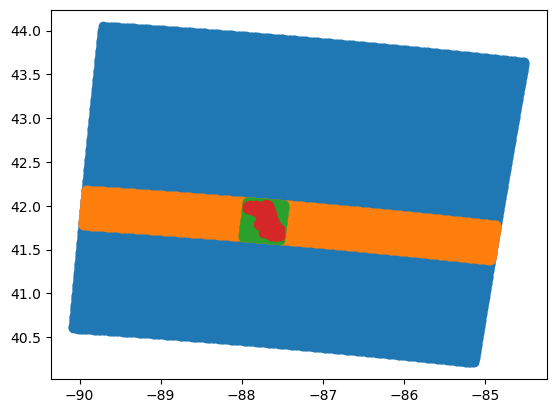

Index to crop:
[98, 132]
[123, 152]
(34, 29)
(34, 29)


In [40]:
lon = np.array(nc.Dataset('../netcdf/latlon_ChicagoLADCO_d03.nc')['lon'])
lat = np.array(nc.Dataset('../netcdf/latlon_ChicagoLADCO_d03.nc')['lat'])
ds = nc.Dataset('/mnt/batch/tasks/shared/LS_root/mounts/clusters/cmaq/code/Users/t-stacym/netcdf/all_crop_wint.nc')

# crop lat,lon,ds to chicago area to make it smaller
lonu,latu = find_index([lon[maskchi].max(),lon[maskchi].min(),lon[maskchi].max(),lon[maskchi].min()], [lat[maskchi].max(),lat[maskchi].max(),lat[maskchi].min(),lat[maskchi].min()], lon, lat)
lonuf = [int(min(lonu)),int(max(lonu))+1]
loncrop,latcrop=lon[lonuf[0]:lonuf[1]],lat[lonuf[0]:lonuf[1]]
lonu,latuf = find_index([lon[maskchi].max(),lon[maskchi].min(),lon[maskchi].max(),lon[maskchi].min()], [lat[maskchi].max(),lat[maskchi].max(),lat[maskchi].min(),lat[maskchi].min()], loncrop, latcrop)
latuf = [int(min(latuf)),int(max(latuf))+1] # can added 4 to remove O'Hare
floncrop,flatcrop = np.array(loncrop.T[latuf[0]:latuf[1]].T),np.array(latcrop.T[latuf[0]:latuf[1]].T)

no2_monthly_crop = np.mean(np.array(ds['NO2']),axis=0)[0][lonuf[0]:lonuf[1]]
pm25_monthly_crop = np.mean(np.array(ds['PM25_TOT']),axis=0)[0][lonuf[0]:lonuf[1]]
no2_monthly_crop = no2_monthly_crop.T[latuf[0]:latuf[1]].T
pm25_monthly_crop = pm25_monthly_crop.T[latuf[0]:latuf[1]].T

pd.DataFrame(no2_monthly_crop).to_csv('cropped_no2_monthly_feb2022_ESPG4326.csv')
pd.DataFrame(pm25_monthly_crop).to_csv('cropped_pm25_monthly_feb2022_ESPG4326.csv')
pd.DataFrame(flatcrop).to_csv('cropped_chi_lat_ESPG4326.csv')
pd.DataFrame(floncrop).to_csv('cropped_chi_lon_ESPG4326.csv')


maskcrop=maskchi[lonuf[0]:lonuf[1]]
maskcrop=maskcrop.T[latuf[0]:latuf[1]].T
pd.DataFrame(maskcrop).to_csv('maskcrop_ESPG4326.csv')


# plot to check steps
plt.figure()
plt.scatter(lon,lat)
plt.scatter(loncrop,latcrop)
plt.scatter(floncrop,flatcrop)
plt.scatter(lon[maskchi],lat[maskchi])
plt.show()

print('Index to crop:')
print(lonuf)
print(latuf)
print(no2_monthly_crop.shape)
print(floncrop.shape)
# ok so use the floncrop,flatcrop subset as lat lon, transform all data using lonuf,latuf indices

In [239]:

# Add in eclipse data
ec = pd.read_csv('~/cloudfiles/code/Users/t-stacym/dataAnalysis/cleaned_and_dropped_wint.csv')

# Add in eclipse data onto CMAQ grid

In [242]:
# h = number of hour days in the model run 
h = 24*31

# Add in eclipse data
ec = pd.read_csv('~/cloudfiles/code/Users/t-stacym/cleaned_and_dropped_wint.csv')

# get x y
ec['x'] =  [int(ec.xx[i].split('(')[1].split(',')[0]) for i in range(len(ec))]
ec['y'] =  [int(ec.xx[i].split(')')[0].split(',')[1]) for i in range(len(ec))]

# 
#ec['ind'] = [(ec.xx[i],ec.xx[i]) for i in range(len(ec))]
ec['datetime'] = pd.to_datetime(ec['Unnamed: 0'])
ec = ec.groupby(['DeviceId','datetime']).mean().reset_index()
ec['hour'] = list(np.arange(0,744))*len(ec.DeviceId.unique())

# make index
ec['ind'] = [(int(ec.x[i]),int(ec.y[i])) for i in range(len(ec))]
# average by index
print(ec)
ec = ec.groupby(['ind','hour']).mean().reset_index()

#ec = ec.reset_index()
ec

# put eclipse on cmaq grid
cmaq_ec_no2 = np.array([np.zeros(lon.shape)*np.nan]*h)
cmaq_ec_pm25 = np.array([np.zeros(lon.shape)*np.nan]*h)

# handling of multiples
for i in range(0,h):
    tmp = ec[ec.hour == i].reset_index()
    for j in range(len(tmp.ind)):
        #print(tmp.ind[j])
        cmaq_ec_pm25[i][tmp.ind[j]] = tmp.CalibratedPM25[j]
        cmaq_ec_no2[i][tmp.ind[j]] = tmp.CalibratedNO2[j]

cmaq_ec_no2 = np.array(cmaq_ec_no2)
cmaq_ec_pm25 = np.array(cmaq_ec_pm25)


       DeviceId            datetime  Unnamed: 0.1   Latitude  Longitude  \
0          2002 2021-08-01 00:00:00        8594.5  41.794921 -87.625857   
1          2002 2021-08-01 01:00:00        8583.0  41.794921 -87.625857   
2          2002 2021-08-01 02:00:00        8571.5  41.794921 -87.625857   
3          2002 2021-08-01 03:00:00        8560.0  41.794921 -87.625857   
4          2002 2021-08-01 04:00:00        8548.5  41.794921 -87.625857   
...         ...                 ...           ...        ...        ...   
75139      2191 2021-08-31 19:00:00           NaN  41.939568 -87.688703   
75140      2191 2021-08-31 20:00:00           NaN  41.939568 -87.688703   
75141      2191 2021-08-31 21:00:00           NaN  41.939568 -87.688703   
75142      2191 2021-08-31 22:00:00      817021.5  41.939568 -87.688703   
75143      2191 2021-08-31 23:00:00      817009.5  41.939568 -87.688703   

               CO       SO2        NO2         O3      TempC  ...         RH  \
0      237.004623  

# add in EPA onto cmaq grid

In [244]:
# Add in EPA data to the grid
#epa_no2 = pd.read_csv('../no2_082021_epa.csv',index_col = 0) 
#epa_pm = pd.read_csv('../pm25_082021_epa.csv',index_col = 0)

epa_no2 = pd.read_csv('../no2_022022_epa.csv',index_col = 0) 
epa_pm = pd.read_csv('../pm25_022022_epa.csv',index_col = 0)


print(epa_pm)

epa_pm=epa_pm.groupby(['hour','sitenum']).mean().reset_index()
epa_no2=epa_no2.groupby(['hour','site_number']).mean().reset_index()


epa_no2['ind'] = [(int(epa_no2.xx[i]),int(epa_no2.yy[i])) for i in range(len(epa_no2))]
epa_pm['ind'] = [(int(epa_pm.xx[i]),int(epa_pm.yy[i])) for i in range(len(epa_pm))]

h = 24*31-2
cmaq_epa_no2 = np.array([np.zeros(lon.shape)*np.nan]*h)
cmaq_epa_pm25 = np.array([np.zeros(lon.shape)*np.nan]*h)


for h in range((h)):
    tmp = epa_no2[epa_no2.hour == h].reset_index()
    for j in range(len(tmp.ind)):
        cmaq_epa_no2[h][tmp.ind[j]] = tmp['sample_measurement'][j]


for h in range((h)):
    tmp = epa_pm[epa_pm.hour == h].reset_index()
    for j in range(len(tmp.ind)):
        cmaq_epa_pm25[h][tmp.ind[j]] = tmp['sample_measurement'][j]
        #print(tmp['Data.sample_measurement'][j])


# now transform with cmaq data  same way as before


      site_number   ReadingDateTimeUTC  poc   latitude  longitude  \
0               1  2021-08-01 00:00:00    3  41.670992 -87.732457   
1               1  2021-08-01 01:00:00    3  41.670992 -87.732457   
2               1  2021-08-01 02:00:00    3  41.670992 -87.732457   
3               1  2021-08-01 03:00:00    3  41.670992 -87.732457   
4               1  2021-08-01 04:00:00    3  41.670992 -87.732457   
...           ...                  ...  ...        ...        ...   
2963         6005  2021-08-31 17:00:00    3  41.864426 -87.748902   
2964         6005  2021-08-31 18:00:00    3  41.864426 -87.748902   
2965         6005  2021-08-31 19:00:00    3  41.864426 -87.748902   
2966         6005  2021-08-31 20:00:00    3  41.864426 -87.748902   
2967         6005  2021-08-31 21:00:00    3  41.864426 -87.748902   

      sample_measurement  detection_limit  CMAQ_PM25   xx   yy  hour  sitenum  
0                   16.1              5.0  10.499123  117  136     0        1  
1          

In [245]:
# make unique ID for latlon pairs (each grid pixel in cropped model domain gets an ID)
from string import ascii_lowercase
length = [letter1+letter2 for letter1 in ascii_lowercase for letter2 in ascii_lowercase]
width = [str(i) for i in range(100,100+len(length))]

u = []
for i in range(floncrop.shape[0]):
    for j in range(floncrop.shape[1]):
        u.append(length[i]+width[j])

#np.array(u).reshape(floncrop.shape)

In [246]:
24*31-2

742

# pull variables out of cmaq  and into a final dataframe 

Where each column corresponds to a lat/lon point

In [247]:
# pull out variables and make hourly
cmaq_var = ['NO2','O3','PM25_TOT','VOC','PBLH','RH','U10','V10','SFC_TMP']

din,hour,lo,la,v = [],[],[],[],[]
dfvar = []

h = 24*31-2 #number of hours in df

# unfold the cmaq data and add to df
for var in cmaq_var:
    print(var)
    for t in range(0,h):
        tmp = ds[var][t][0][lonuf[0]:lonuf[1]]
        tmp = np.asarray(tmp.T[latuf[0]:latuf[1]].T).ravel()
        if t == 0: 
            din = tmp
            hour = np.array([t]*len(tmp.ravel()))
            lo = np.array(floncrop.ravel())
            la = np.array(flatcrop.ravel())
            v = np.array([var]*len(tmp.ravel()))
        else: 
            din = np.append(din,tmp.ravel(),axis=0)
            hour = np.append(hour,np.array([t]*len(tmp.ravel())),axis=0)
            lo = np.append(lo,np.array(floncrop.ravel()),axis=0)
            la = np.append(la,np.array(flatcrop.ravel()),axis=0)
    dfvar.append(din)

h = 24*31-2 #number of hours in df

dfvar_ec = []
# unfold the eclipse from cmaq_grid
for t in range(0,h):
        tmp = cmaq_ec_no2[t][lonuf[0]:lonuf[1]]
        tmp2 = cmaq_ec_pm25[t][lonuf[0]:lonuf[1]]
        tmp = np.array(tmp.T[latuf[0]:latuf[1]].T).ravel()
        tmp2 = np.array(tmp2.T[latuf[0]:latuf[1]].T).ravel()
        if t == 0: 
            din = tmp
            din2 = tmp2
        else: 
            din = np.append(din,tmp.ravel(),axis=0)
            din2= np.append(din2,tmp2.ravel(),axis=0)

dfvar_ec = [din,din2]
print('Done eclipse')

h = 24*31-2 #number of hours in df

dfvar_epa = []
# unfold the epa from cmaq_grid
for t in range(0,h):
        tmp = cmaq_epa_no2[t][lonuf[0]:lonuf[1]]
        tmp2 = cmaq_epa_pm25[t][lonuf[0]:lonuf[1]]
        tmp = np.array(tmp.T[latuf[0]:latuf[1]].T).ravel()
        tmp2 = np.array(tmp2.T[latuf[0]:latuf[1]].T).ravel()
        if t == 0: 
            din = tmp
            din2 = tmp2
        else: 
            din = np.append(din,tmp.ravel(),axis=0)
            din2= np.append(din2,tmp2.ravel(),axis=0)


dfvar_epa = [din,din2]
print('Done EPA')



NO2
O3
PM25_TOT
VOC
PBLH
RH
U10
V10
SFC_TMP
Done eclipse
Done EPA


In [248]:
df = [dfvar[0],dfvar[1],dfvar[2],dfvar[3],dfvar[4],dfvar[5],dfvar[6],dfvar[7],dfvar[8],dfvar_ec[0],dfvar_ec[1],dfvar_epa[0],dfvar_epa[1],hour,lo,la, u*h]
df = pd.DataFrame(df).T
df.columns = cmaq_var +['ec_NO2','ec_PM25']+['epa_NO2','epa_PM25'] + ['hour'] + ['lon'] + ['lat'] + ['u']

df.to_csv('ec_on_cmaq_wint.csv')

print(df)
del df # add in preceding hour from eclipse?

             NO2       O3 PM25_TOT      VOC     PBLH       RH      U10  \
0        4.52818  42.1037  10.7302  33.9924   1182.7  48.4762  2.75125   
1        4.21354  41.9005  10.7965  34.4083  1079.19  48.7679  2.71756   
2        4.04171   42.006  11.7073  34.5579  600.028  48.6107  2.89178   
3        4.11176  42.0538  12.0235  34.6817  1247.28  48.4239  2.92613   
4        3.86309  41.8945  12.7131  35.1165  1065.71   48.374  2.83596   
...          ...      ...      ...      ...      ...      ...      ...   
731607  0.169859  50.7171  5.48676  12.7053  127.394  80.3161 -3.48859   
731608  0.170557  50.5779  5.50117  12.9943  126.649  80.4251 -3.45482   
731609  0.171369  50.4606  5.52079  13.2908  125.899  80.5971 -3.41895   
731610   0.17231  50.3655  5.54899  13.5909  125.071  80.8333 -3.37913   
731611  0.173345  50.2884  5.58012  13.8895  124.134  81.1138 -3.33434   

              V10  SFC_TMP ec_NO2 ec_PM25 epa_NO2 epa_PM25 hour      lon  \
0      -0.0721776   25.824    NaN  

In [249]:
df = pd.read_csv('ec_on_cmaq_wint.csv',index_col =0)
df['WS'] = np.sqrt(df.U10**2+df.V10**2)
df.to_csv('ec_on_cmaq_wint.csv')
del df


print('Added WSPD to file')

Added WSPD to file


In [250]:
df = pd.read_csv('ec_on_cmaq_wint.csv',index_col =0)

In [251]:
len(df.ec_NO2.unique())

42664

# Pull other datasets from planetary computer


Need to regrid the data to the chicago grid

Metdata is not on planetary comp

# add in reanalysis data

In [21]:
# August
etr = nc.Dataset('../netcdf/metdata/etr_2021.nc') # evapotransipration
pr = nc.Dataset('../netcdf/metdata/pr_2021.nc') # precip amount
srad = nc.Dataset('../netcdf/metdata/srad_2021.nc') # shortwave flux
th = nc.Dataset('../netcdf/metdata/th_2021.nc') # wind from direction
tmmx = nc.Dataset('../netcdf/metdata/tmmx_2021.nc') # air temp
vs = nc.Dataset('../netcdf/metdata/vs_2021.nc') # wind speed
sph = nc.Dataset('../netcdf/metdata/sph_2021.nc') # specific humidity
rmin = nc.Dataset('../netcdf/metdata/rmin_2021.nc') # relative humidity

# February
srad = nc.Dataset('../netcdf/metdata/srad_2022.nc') # shortwave flux
th = nc.Dataset('../netcdf/metdata/th_2022.nc') # wind from direction
tmmx = nc.Dataset('../netcdf/metdata/tmmx_2022.nc') # air temp
vs = nc.Dataset('../netcdf/metdata/vs_2022.nc') # wind speed
rmin = nc.Dataset('../netcdf/metdata/rmin_2022.nc') # relative humidity


# pull in xlonxlat
flatcrop = np.array(pd.read_csv('cropped_chi_lat_ESPG4326.csv',index_col = 0))
floncrop = np.array(pd.read_csv('cropped_chi_lon_ESPG4326.csv',index_col = 0))


In [25]:
data = th
print(tmmx['air_temperature'])

# reproject dataset so that we can put it on the same crs as the cmaq data
xv, yv = np.meshgrid(np.array(data['lon']), np.array(data['lat']))

# regrid data so that it can be added to metdata
grid_out = {"lon": floncrop, "lat": flatcrop}
grid_in = {"lon": xv, "lat": yv}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")

# make for wind direction, air temp, and shortwave flux
winddir,ws,airt,sf,rh = [],[],[],[],[]
#for t in range(213,244):
for t in range(32,60):
    winddir.append(regridder(np.array(data['wind_from_direction'][t])))
    airt.append(regridder(np.array(tmmx['air_temperature'][t])))
    sf.append(regridder(np.array(srad['surface_downwelling_shortwave_flux_in_air'][t])))
    ws.append(regridder(np.array(vs['wind_speed'][t])))
    rh.append(regridder(np.array(rmin['relative_humidity'][t])))

winddir = np.array(winddir)
airt,sf,rh,ws = np.array(airt),np.array(sf),np.array(rh),np.array(ws)
print(airt.min(),airt.max())

<class 'netCDF4._netCDF4.Variable'>
uint16 air_temperature(day, lat, lon)
    _FillValue: 32767
    units: K
    description: Daily Maximum Temperature (2m)
    long_name: tmmx
    standard_name: tmmx
    missing_value: 32767
    dimensions: lon lat time
    grid_mapping: crs
    coordinate_system: WGS84,EPSG:4326
    scale_factor: 0.1
    add_offset: 220.0
    coordinates: lon lat time
    _Unsigned: true
unlimited dimensions: 
current shape = (211, 585, 1386)
filling on
265.4008013424591 32767.000000000004


In [26]:
# remove missing values
fv = 32767
fv = 900
winddir[winddir > 360] = np.nan
sf[sf > fv] = np.nan
airt[airt > 350] = np.nan
rh[rh > 110] = np.nan
ws[ws > 100] = np.nan

#for t in range(len(winddir)):
#    winddir[t][winddir[t] > 360] = np.nan
#    winddir[t][winddir[t] < 0] = np.nan
#    sf[t][sf[t] > 500] = np.nan
#    sf[t][sf[t] < 0] = np.nan
#    airt[t][airt[t] > 273+50] = np.nan
#    airt[t][airt[t] < 273-20] = np.nan
#    ws[t][ws[t] > 200] = np.nan
    

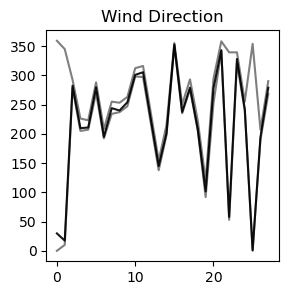

In [28]:
fig,ax = plt.subplots(figsize=(3,3))
#ax2 = ax.twinx()
ax.plot([np.nanmean(winddir[i]) for i in range(len(winddir))],c='k',alpha = 0.9)
ax.plot([np.nanmax(winddir[i]) for i in range(len(winddir))],c='k',alpha = 0.5)
ax.plot([np.nanmin(winddir[i]) for i in range(len(winddir))],c='k',alpha = 0.5)
ax.set_title('Wind Direction')
#ax2.plot([np.nanmean(airt[i]) for i in range(len(winddir))],c='b',alpha = 0.9)
#ax2.plot([np.nanmax(airt[i]) for i in range(len(winddir))],c='b',alpha = 0.5)
#ax2.plot([np.nanmin(airt[i]) for i in range(len(winddir))],c='b',alpha = 0.5)

plt.show()

#f = pd.read_csv('../dataAnalysis/data_cleaned_and_dropped.csv',index_col = 0)
#no2_cmaq = np.array(pd.read_csv('../netCDF/all_no2.nc')['NO2'])

f = pd.read_csv('../dataAnalysis/cleaned_data_wint.csv',index_col = 0)

In [29]:
# make unique ID for latlon pairs (each grid pixel in cropped model domain gets an ID)
from string import ascii_lowercase
length = [letter1+letter2 for letter1 in ascii_lowercase for letter2 in ascii_lowercase]
width = [str(i) for i in range(100,100+len(length))]

u = []
for i in range(floncrop.shape[0]):
    for j in range(floncrop.shape[1]):
        u.append(length[i]+width[j])

u = np.array(u)
print(len(u.ravel()))
print(len(floncrop.ravel()))

idout = pd.DataFrame([u,floncrop.ravel(),flatcrop.ravel()]).T
#idout.columns = ['u','lon','lat']
#idout.to_csv('u_lon_lat_labels_for_grid.csv')

986
986


In [30]:
# make df
for i in range(len(winddir)):
    for t in range(24):
        if (i == 0) & (t == 0):
            a = np.array([winddir[i].ravel(),airt[i].ravel(),sf[i].ravel(),rh[i].ravel(),ws[i].ravel(),[int(i*24+t)]*len(floncrop.ravel()),u.ravel()])
        else:
            b  = np.array([winddir[i].ravel(),airt[i].ravel(),sf[i].ravel(),rh[i].ravel(),ws[i].ravel(),[int(i*24+t)]*len(floncrop.ravel()),u.ravel()])
            a = np.append(a,b,axis=1)

In [31]:
# make df of model data
reanout = pd.DataFrame(a.T,columns = ['winddir_rean','airt_rean','sf_rean','rh_rean','ws_rean','hour','u'])
reanout['hour'] = [int(reanout['hour'][i]) for i in range(len(reanout))]

reanout['winddir_rean'] = reanout['winddir_rean'].astype(float)
reanout['airt_rean'] = reanout['airt_rean'].astype(float)
reanout['sf_rean'] = reanout['sf_rean'].astype(float)
reanout['rh_rean'] = reanout['rh_rean'].astype(float)
reanout['ws_rean'] = reanout['ws_rean'].astype(float)

reanout = reanout.groupby(['u']).mean().reset_index()

reanout.to_csv('reanalysis_feb2022.csv')

# add to eclipse data
#df = pd.read_csv('ec_on_cmaq.csv',index_col = 0)
reanout

,u,winddir_rean,airt_rean,sf_rean,rh_rean,ws_rean,hour
0,aa100,217.686843,275.053967,105.073289,49.484729,5.176062,335.5
1,aa101,215.708802,275.141416,104.883716,49.175617,5.164290,335.5
2,aa102,215.645274,275.247638,104.692352,48.804663,5.157314,335.5
3,aa103,215.581117,275.347493,104.499833,48.464396,5.150208,335.5
4,aa104,215.517571,275.340342,104.539816,48.600871,5.130569,335.5
...,...,...,...,...,...,...,...
981,bh124,NaN,NaN,NaN,NaN,NaN,335.5
982,bh125,NaN,NaN,NaN,NaN,NaN,335.5
983,bh126,NaN,NaN,NaN,NaN,NaN,335.5
984,bh127,NaN,NaN,NaN,NaN,NaN,335.5


In [32]:
for col in reanout.columns:
    if col != reanout.columns[0]:
        print(col)
        print(reanout[col].mean(),reanout[col].min(),reanout[col].max())


winddir_rean
215.91067902061283 211.77919178746708 355.34121779413925
airt_rean
275.0956386046691 274.4667506350051 289.11071033038905
sf_rean
103.38275674413522 96.2633004419687 783.2267952932305
rh_rean
49.40440373878468 46.32150015444214 66.4846862765059
ws_rean
5.385544248219769 4.891440765097845 19.397642230916233
hour
335.5 335.5 335.5


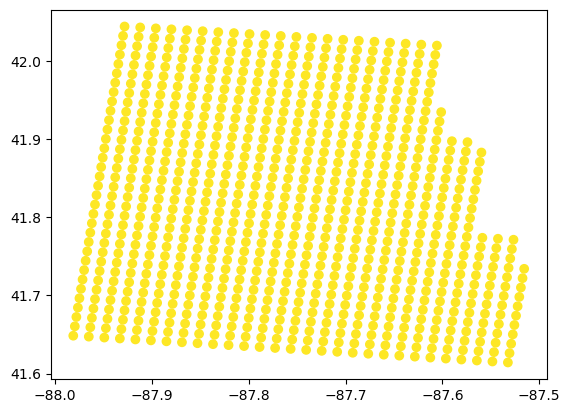

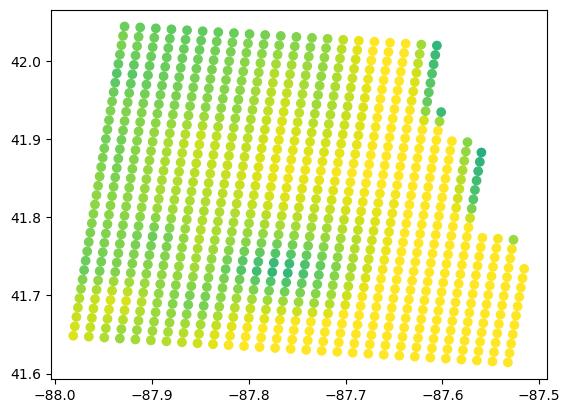

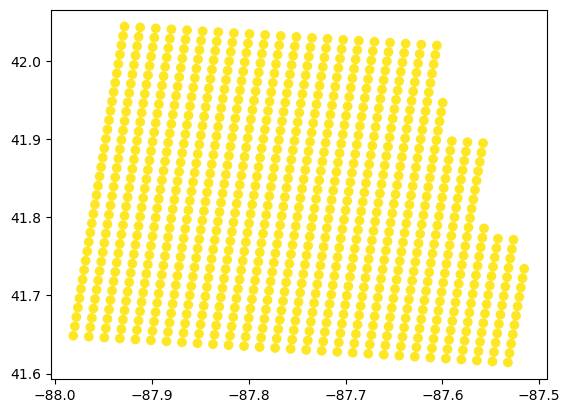

In [33]:
plt.scatter(floncrop.ravel(),flatcrop.ravel(),c=reanout.ws_rean,vmin = 3.5,vmax=4.2)
plt.show()

plt.scatter(floncrop.ravel(),flatcrop.ravel(),c=reanout.rh_rean,vmin=40,vmax=50)
plt.show()

plt.scatter(floncrop.ravel(),flatcrop.ravel(),c=reanout.winddir_rean,vmin=160,vmax=180)
plt.show()

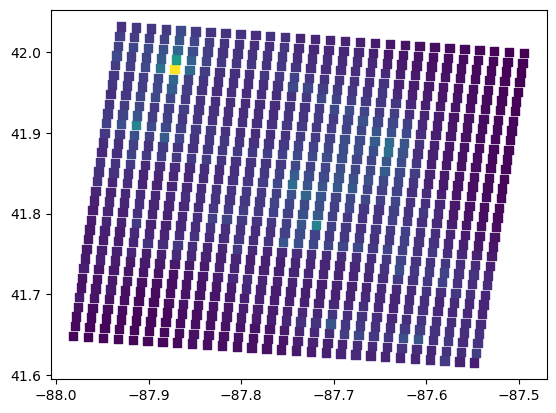

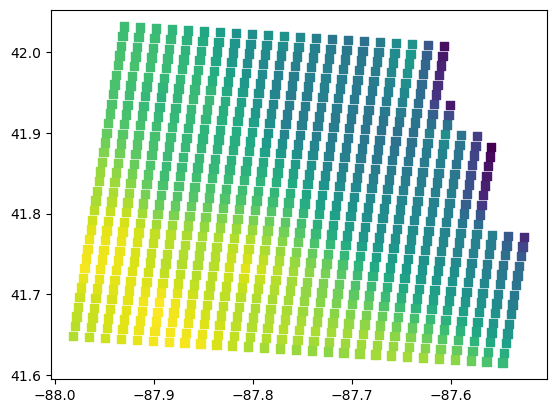

In [258]:
dfout = pd.merge(df,reanout,on=['u','hour'])
print(list(dfout.head()))
print(dfout.airt_rean)
dfout['winddir_rean'] = [float(dfout['winddir_rean'][i]) for i in range(len(dfout))]

dfout['sf_rean'] = [float(dfout['sf_rean'][i]) for i in range(len(dfout))]

dfout['airt_rean'] = [float(dfout['airt_rean'][i]) for i in range(len(dfout))]

tmp = dfout.groupby('u').mean()

plt.scatter(tmp.lon,tmp.lat,c=tmp.NO2,marker='s')
plt.show()

plt.scatter(tmp.lon,tmp.lat,c=tmp.airt_rean,marker='s')
plt.show()

dfout.to_csv('ec_on_cmaq_wint.csv')

# Given wind direction, add NO2/pm upwind

In [277]:
def get_wind_arr(dir,din):
    # dir = wind direction
    # din = np array of m x n size with data
    # return dout = np array of m x n size with data from upwind pixel
    fill = np.zeros(din.shape)
    for i in range(din.shape[0]):
        for j in range(din.shape[1]):
            if (i == 0) or (j == 0) or (i == din.shape[0]-1) or (j == din.shape[1]-1):
                fill[i][j] = din[i][j]
            else:
                if (dir >= 360-45/2)&(dir <= 45/2):
                    fill[i][j] = din[i+1][j+1]
                elif (dir > 45/2)&(dir <=90-45/2):
                    fill[i][j] = din[i+1][j]
                elif (dir > 90-45/2)&(dir <=135-45/2):
                    fill[i][j] = din[i+1][j-1]
                elif (dir > 135-45/2)&(dir <= 180-45/2):
                    fill[i][j] = din[i][j-1]
                elif (dir > 180-45/2)&(dir <= 225-45/2):
                    fill[i][j] = din[i-1][j-1]
                elif (dir > 225-45/2)&(dir <=270-45/2):
                    fill[i][j] = din[i-1][j]
                elif (dir > 270-45/2)&(dir <=305-45/2):
                    fill[i][j] = din[i-1][j+1]
                else: # (dir > 315-45/2)&(dir <=360-45/2):
                    fill[i][j] = din[i][j+1]
    return fill


In [278]:
# pull out variables and make hourly
cmaq_var = ['NO2','O3','PM25_TOT']

din,hour,lo,la,v = [],[],[],[],[]
dfvar = []

h = 24*31-2 #number of hours in df

import math
# unfold the cmaq data and add to df
for var in cmaq_var:
    print(var)
    for t in range(0,h):
        tmp = ds[var][t][0][lonuf[0]:lonuf[1]]
        tmp = np.asarray(tmp.T[latuf[0]:latuf[1]].T)
        if t == 0: hind = 0; 
        else: hind = math.ceil((t+0.1)/24)-1
        #print(hind,t)
        if t == 0: 
            dir = winddir[hind].mean()
            din = get_wind_arr(dir,tmp).ravel()
            hour = np.array([t]*len(tmp.ravel()))
            lo = np.array(floncrop.ravel())
            la = np.array(flatcrop.ravel())
        else:
            dir = winddir[hind].mean() 
            din = np.append(din,get_wind_arr(dir,tmp).ravel(),axis=0)
            hour = np.append(hour,np.array([t]*len(tmp.ravel())),axis=0)
            lo = np.append(lo,np.array(floncrop.ravel()),axis=0)
            la = np.append(la,np.array(flatcrop.ravel()),axis=0)
    dfvar.append(din)


NO2
O3
PM25_TOT


In [261]:
dfin = pd.read_csv('ec_on_cmaq_wint.csv',index_col = 0)
dfin['no2_upwind'] = [float(dfvar[0][i]) for i in range(len(dfvar[0]))]
dfin['o3_upwind'] = [float(dfvar[1][i]) for i in range(len(dfvar[1]))]
dfin['pm25_upwind'] = [float(dfvar[2][i]) for i in range(len(dfvar[0]))]
dfin.to_csv('ec_on_cmaq_wint.csv')

ValueError: Length of values (731612) does not match length of index (685608)

In [ ]:
dfin = pd.read_csv('ec_on_cmaq_wint.csv',index_col = 0)

In [ ]:
dfin = dfin.drop(['Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1'],axis=1)
dfin.to_csv('ec_on_cmaq_wint.csv')

In [ ]:
dfin = pd.read_csv('ec_on_cmaq_wint.csv',index_col = 0)
#dfin['no2_upwind'] = [float(dfvar[0][i]) for i in range(len(dfvar[0]))]
#dfin['o3_upwind'] = [float(dfvar[1][i]) for i in range(len(dfvar[1]))]
#dfin['pm25_upwind'] = [float(dfvar[2][i]) for i in range(len(dfvar[0]))]

print(dfin)
tmp = dfin.groupby('u').mean()

plt.scatter(tmp.lon,tmp.lat,c=tmp.NO2,marker='s')
plt.show()

plt.scatter(tmp.lon,tmp.lat,c=tmp.airt_rean,marker='s')
plt.show()


plt.scatter(tmp.lon,tmp.lat,c=tmp.no2_upwind,marker='s')
plt.show()

# get NDVI from planetary computer

In [34]:
# pull other datasets
import odc.stac
import planetary_computer
from pystac.extensions.raster import RasterExtension
from pystac_client import Client
import rich
import fsspec
import matplotlib.pyplot as plt
import pystac
import xarray as xr
import warnings
from pyproj import Transformer
import numpy as np
import pandas as pd
warnings.simplefilter("ignore", RuntimeWarning)

In [35]:
# get ndvi
# CHi

flatcrop = np.array(pd.read_csv('cropped_chi_lat_ESPG4326.csv',index_col = 0))
floncrop = np.array(pd.read_csv('cropped_chi_lon_ESPG4326.csv',index_col = 0))


buffer = .5
bbox = [floncrop.mean() - buffer, flatcrop.mean() - buffer, floncrop.mean() + buffer, flatcrop.mean() + buffer]
year = "2022"
months = {
    "February": "02",
}
items = dict()

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
for name, number in months.items():
    datetime = f"{year}-{number}"
    search = catalog.search(
        collections=["modis-13A1-061"],
        bbox=bbox,
        datetime=datetime,
    )
    item = search.get_all_items()[0]
    items[name] = planetary_computer.sign(item)

print(items)

data = odc.stac.load(
    items.values(),
    crs="EPSG:3857",
    bands="500m_16_days_NDVI",
    resolution=500,
    bbox=bbox,
)
raster = RasterExtension.ext(items["February"].assets["500m_16_days_NDVI"])
data = data["500m_16_days_NDVI"] * raster.bands[0].scale

data

{'February': <Item id=MYD13A1.A2022057.h11v04.061.2022076061249>}


<xarray.DataArray '500m_16_days_NDVI' (time: 1, y: 299, x: 224)>
array([[[ 0.2573,  0.2573,  0.2939, ..., -0.3   , -0.3   , -0.3   ],
        [ 0.3073,  0.2721,  0.2721, ..., -0.3   , -0.3   , -0.3   ],
        [ 0.3073,  0.3073,  0.2721, ..., -0.3   , -0.3   , -0.3   ],
        ...,
        [ 0.2746,  0.2795,  0.292 , ...,  0.3409,  0.3449,  0.276 ],
        [ 0.2746,  0.2746,  0.2795, ...,  0.2691,  0.3409,  0.3449],
        [ 0.3134,  0.2882,  0.2882, ...,  0.2528,  0.2528,  0.2442]]])
Coordinates:
  * y            (y) float64 5.21e+06 5.21e+06 5.209e+06 ... 5.062e+06 5.061e+06
  * x            (x) float64 -9.822e+06 -9.821e+06 ... -9.711e+06 -9.71e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-02-26

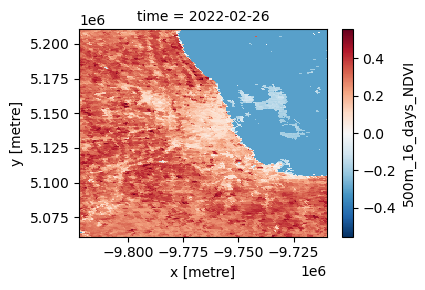

In [36]:
data.plot.imshow(col="time")
plt.show()

In [37]:
# reproject dataset so that we can put it on the same crs as the cmaq data
xv, yv = np.meshgrid(data.x, data.y)

transformer = Transformer.from_crs(data.x.crs, "epsg:4326",always_xy=True) 

mlon, mlat = transformer.transform(xv, yv)
data.coords['lon'] = (('y', 'x'), mlon)
data.coords['lat'] = (('y', 'x'), mlat)
data.attrs['crs']  = '+init=epsg:4326'

data

<xarray.DataArray '500m_16_days_NDVI' (time: 1, y: 299, x: 224)>
array([[[ 0.2573,  0.2573,  0.2939, ..., -0.3   , -0.3   , -0.3   ],
        [ 0.3073,  0.2721,  0.2721, ..., -0.3   , -0.3   , -0.3   ],
        [ 0.3073,  0.3073,  0.2721, ..., -0.3   , -0.3   , -0.3   ],
        ...,
        [ 0.2746,  0.2795,  0.292 , ...,  0.3409,  0.3449,  0.276 ],
        [ 0.2746,  0.2746,  0.2795, ...,  0.2691,  0.3409,  0.3449],
        [ 0.3134,  0.2882,  0.2882, ...,  0.2528,  0.2528,  0.2442]]])
Coordinates:
  * y            (y) float64 5.21e+06 5.21e+06 5.209e+06 ... 5.062e+06 5.061e+06
  * x            (x) float64 -9.822e+06 -9.821e+06 ... -9.711e+06 -9.71e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2022-02-26
    lon          (y, x) float64 -88.23 -88.23 -88.22 ... -87.24 -87.23 -87.23
    lat          (y, x) float64 42.33 42.33 42.33 42.33 ... 41.33 41.33 41.33
Attributes:
    crs:      +init=epsg:4326

# Now regrid the NDVI data

In [38]:
# regrid data so that it can be added to metdata
grid_out = {"lon": floncrop, "lat": flatcrop}
grid_in = {"lon": mlon, "lat": mlat}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
ndvi_crop = regridder(np.array(data)[0])


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


<ipython-input-39-f791ae769dae>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(floncrop,flatcrop,ndvi_crop,cmap = 'RdBu_r',vmin = -1,vmax = 1)
<ipython-input-39-f791ae769dae>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mlon,mlat,np.array(data)[0],vmin = -1,vmax = 1, cmap = 'RdBu_r',alpha=.1)


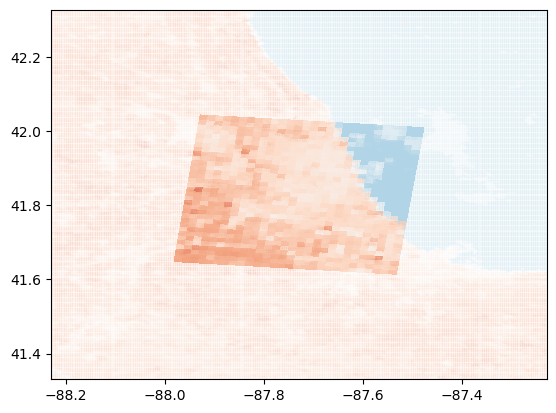

In [39]:
plt.pcolormesh(floncrop,flatcrop,ndvi_crop,cmap = 'RdBu_r',vmin = -1,vmax = 1)
plt.pcolormesh(mlon,mlat,np.array(data)[0],vmin = -1,vmax = 1, cmap = 'RdBu_r',alpha=.1)
plt.show()

In [20]:
# write out to DF
pd.DataFrame(ndvi_crop).to_csv('NDVI_crop_feb2022.csv')

In [268]:
# add ndvi to df by ravelling and repeating
df = pd.read_csv('ec_on_cmaq_wint.csv',index_col =0)
df['NDVI'] = list(np.array(ndvi_crop.ravel()))*int(len(df)/len(ndvi_crop.ravel()))
# out to csv
df.to_csv('ec_on_cmaq_wint.csv')
del df

print('Added NDVI to file')

ValueError: Length of values (685270) does not match length of index (685608)

In [4]:
import requests
import json
import pandas as pd

url = requests.get("https://data.cityofchicago.org/resource/sxs8-h27x.json?$where=time is between '2021-08-10T14:00:00' and '2021-08-10T16:00:00'")
text = url.text
data_dict_list = json.loads(text)




traffic_speed = []
if isinstance(data_dict_list, list):
            traffic_speed += data_dict_list



traffic_speed = pd.DataFrame.from_records(traffic_speed)
traffic_speed.tail()

""


In [125]:
traffic_speed['speed']=traffic_speed['speed'].astype(float)
traffic_speed.groupby('segment_id').mean()

KeyError: 'segment_id'